# Lab 8. Linear regression & neural networks

#### Table of contents

1. Overview
2. About the QM7 dataset
3. Prepare the data
4. Linear regression
5. Neural network and feedforward

## 1. Overview

In this lab session we will predict the atomization energies of some small molecules based on linear regression, and we will start building up a neural network.

## 2. The QM7 dataset

This dataset is an extension of the QM7 dataset for multitask learning where 13 additional properties (e.g. polarizability, HOMO and LUMO eigenvalues, excitation energies) have to be predicted at different levels of theory (ZINDO, SCS, PBE0, GW). Additional molecules comprising chlorine atoms are also included, totalling 7211 molecules.
The dataset is composed of two multidimensional arrays $X$ ($7211\times 23\times 23$) and $T$ ($7211\times 14$) representing the inputs (Coulomb matrices) and the labels (molecular properties) and one array names of size 14 listing the names of the different properties.
More details are provided in this [paper](https://iopscience.iop.org/article/10.1088/1367-2630/15/9/095003/meta).

Basically, the datatset contains features to describe some small molecules (these features are called Coulomb matrices) and various molecular properties (14) as follow:

1. Atomization energies (PBE0, unit: kcal/mol)
2. Excitation of maximal optimal absorption (ZINDO, unit: eV)
3. Absorption Intensity at maximal absorption (ZINDO)
4. Highest occupied molecular orbital HOMO (ZINDO, unit: eV)
5. Lowest unoccupied molecular orbital LUMO (ZINDO, unit: eV)
6. First excitation energy (ZINDO, unit: eV)
7. Ionization potential IP (ZINDO, unit: eV)
8. Electron affinity EA (ZINDO, unit: eV)
9. Highest occupied molecular orbital HOMO (PBE0, unit: eV)
10. Lowest unoccupied molecular orbital LUMO (PBE0, unit: eV)
11. Highest occupied molecular orbital HOMO (GW, unit: eV)
12. Lowest unoccupied molecular orbital LUMO (GW, unit: eV)
13. Polarizabilities (PBE0, unit: $A^3$)
14. Polarizabilities (SCS, unit: $A^3$)

Because these properties are complicated to compute, methods based on machine learning can be trained to predict them based on some meaningfull features. Coulomb matrices are such good representations.

A Coulmb matrix is defined based on the atomic positions $R_i$ and atomic charges $Z_i$ of atoms in a molecule as:

$M_{IJ}=\left\{
\begin{array}{ll}
0.5Z_I^{2.4}\text{ for }I=J\\
\frac{Z_IZ_J}{|R_I-R_J|}\text{ for }I\neq J\\
\end{array}
\right.
$

Here, the Coulomb matrices are already computed and provided in the training set.

## 3. Prepare the data

Let's first load the data. Here the data is in a slightly different format than usual and we will use the `loadmat` method from `scipy`.

In [372]:
from scipy.io import loadmat
qm7 = loadmat('qm7b.mat')

The input data is provided as the arrays `X` that we will store to start in the variable `X0`.

In [373]:
import numpy as np
X0 = qm7['X']
X0.shape

(7211, 23, 23)

We see that the dataset is composed of $7211$ molecules each described by a $23\times 23$ (Coulomb) matrix. In order to use these matrices as input for linear regression, we need to reshape them into 1D arrays. In other word, we will unroll each $23\times 23$ matrix into an array of length $23*23 = 529$. 

In [374]:
X = X0.reshape(7211,529)
print(X.shape)

(7211, 529)


We will try to predict the atomization energies (property number 1). We can access these energies with the `T` argument and selecting the first column of the resulting array. We also multiply by $0.043$ to convert the energies from kcal/mol to eV.

In [375]:
y = qm7['T'][:,0]*0.043
y.shape

(7211,)

Let's split the dataset into training, validation and test sets. We will use sklearn method to do that.

__Q.1.__ Define the variables `train_test_ratio` and `test_val_ratio` such that we obtain a training set of 60%, a test set of 20% and a validation set of 20% of the initial number of examples in the dataset. You must not modify anything of the following code beside the definition of the two variables aformentioned (1 mark).

In [376]:
from sklearn.model_selection import train_test_split

### BEGIN SOLUTION
### END SOLUTION

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = train_test_ratio,random_state=21)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,test_size = test_val_ratio,random_state=22)
print(X_train.shape,X_test.shape,X_val.shape)

(4326, 529) (1442, 529) (1443, 529)


## 4. Linear regression

We can now use linear regression to fit the data in the training set.

In [377]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

__Q.2.__ Compute the root mean squared error (RMSE) of the optimized model based on the validation set and assign the value to the variable `rmse`. You will first predict the values of the validation set based on the previous model (the instance `model`) then you will compute the RMSE between the actual validation outputs and that predicted by the model (2 marks).

In [378]:
from sklearn.metrics import mean_squared_error

### BEGIN SOLUTION
### END SOLUTION

print('RMSE on the validation set:',rmse,'eV')

RMSE on the validation set: 4.976970482640481 eV


We would like now to perfom K-fold cross validation to get a better estimate of the validation error.

__Q.3.__ Complete the function below to perfom K-fold cross validation. The function must return a list of length K containing the RMSE evaluated over each cross validation fold. Here is what you must do:

- fit the `clone_model` over each of the training set folds 
- predict the `clone_model` over each of the validation folds
- compute the RMSE based on the validation predictions 

(2 marks)

In [384]:
from sklearn.base import clone


def kfold_cross(model,nfolds,X,y):
    
    # This function splits the dataset into nfolds subsets
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=11)

    rmse_list = []
    
    # kf.split(X) returns the indices of the training and validation sets folds
    for train_index, val_index in kf.split(X):
        
        # This copies the linear regression model to clone_model
        clone_model = clone(model)
        
        # Here we prepare the training and validation folds
        X_train_folds = X[train_index]
        y_train_folds = y[train_index]
        X_val_folds = X[val_index]
        y_val_folds = y[val_index]  
    
        ### BEGIN SOLUTION
        ### END SOLUTION
        
        rmse_list.append(rmse)
    return rmse_list

nfolds = 10
X_train_val = np.concatenate((X_train,X_val), axis=0)
y_train_val = np.concatenate((y_train,y_val), axis=0)
rmse_list = kfold_cross(model,nfolds,X_train_val,y_train_val)
print(nfolds,'-fold X-validation mean:',np.mean(rmse_list),'+/-',np.std(rmse_list),'eV')

(5769, 529) (4326, 529)
10 -fold X-validation mean: 4.704348919737168 +/- 1.5357974815820854 eV


We note that K-fold validation error is more precise than the validation based on a single fold because we now have access to the mean and standard deviation of the RMSE representative of the entire training+validation dataset. We can finally visualize the predicted data versus the actual data based on the training set and the test set.

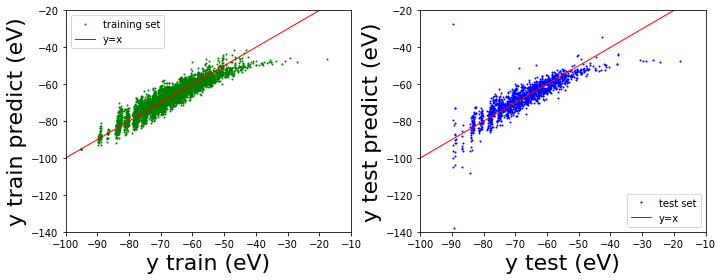

In [386]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

xi = np.linspace(-1000,1000)

plt.figure(figsize=(10,4))
ax = plt.subplot(1, 2, 1)
y_train_predict = model.predict(X_train)
ax.plot(y_train,y_train_predict,marker='.',lw=0,color='g',ms=2,label='training set')
ax.plot(xi,xi,color='r',lw=1,label='y=x')
ax.set_ylim(-140,-20)
ax.set_xlim(-100,-10)
ax.set_xlabel('y train (eV)',fontsize=22)
ax.set_ylabel('y train predict (eV)',fontsize=22)
ax.legend()

ax = plt.subplot(1, 2, 2)
y_test_predict = model.predict(X_test)
ax.plot(y_test,y_test_predict,marker='.',lw=0,color='b',ms=2,label='test set')
ax.plot(xi,xi,color='r',lw=1,label='y=x')
ax.set_ylim(-140,-20)
ax.set_xlim(-100,-10)
ax.set_xlabel('y test (eV)',fontsize=22)
ax.set_ylabel('y test predict (eV)',fontsize=22)
ax.legend()

plt.tight_layout()
plt.show()

We can clearly see that the model performs better on the training set than the test set, as expected.

## 5. Neural network and feedforward

In this section, we would like to compute the output value of each neuron layer by layer.
We provide below a function to initialize (based on random numbers) biases and weights of a feedforward neural network of any size. You should play with the list `sizes` to be sure you understand the shape of the bias vectors and weight matrices (more below).

In [387]:
from numpy.random import RandomState

def network(sizes):
    prng = RandomState(1) # seed for random numbers
    biases = [prng.randn(y, 1) for y in sizes[1:]]
    weights = [prng.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
    return biases, weights

# default sizes = [3,4,4,2]
sizes = [3,4,4,2]
biases,weights = network(sizes)
print('Neural network architecture:',sizes)
print('We should expect:',len(sizes)-1,'bias vectors and',len(sizes)-1,'weight matrices')
print('Bias vectors shape:',[bias.shape for bias in biases])
print('Weight matrices shape:',[weight.shape for weight in weights])

Neural network architecture: [3, 4, 4, 2]
We should expect: 3 bias vectors and 3 weight matrices
Bias vectors shape: [(4, 1), (4, 1), (2, 1)]
Weight matrices shape: [(4, 3), (4, 4), (2, 4)]


The default size $[3,4,4,2]$ corresponds to a neural network of 3 input neurons (3 neurons in the 1st layer), 4 neurons in the 1st hidden layer (the 2nd layer), 4 neurons in the 2nd hidden layer (the 3rd layer) and 2 neurons in the output layer (the 4th layer). Therefore, the network can be decomposed into 3 bias vectors and matrices: corresponding to the 2nd, 3rd and 4th layers because there is no bias and weight in the input layer. The bias vectors are of shape $(k,1)$ with $k$ the number of neurons in the layer $l$. The weight matrices are of shape $(j,k)$ with $j$ the number of neurons in the $l$ layer and $k$ the number of neurons in the $(l-1)$ layer.

We would like to compute the outpout of each neuron based on a given input. We will need an activation function. Let's explore various activation functions staring with the step function.

__Q.4.__ Complete the function below that takes in a list (or an array) of values and returns the corresponding list of zeros and ones based on the step function activation. If a given value in the input `z` array is less or equal than zero, the function appends zero to the output list and if the value is strictly greater than zero, it appends a one (1 mark).

In [388]:
def step(z):
    out_list = []
    
    ### BEGIN SOLUTION
    ### END SOLUTION
    
    return out_list

We provide below the sigmoid function.

In [389]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

__Q.5.__ Complete the function `tanh` that returns the hyperbolic tangeant of a given input list (or array) `z`. The function takes in the list (or array) `z` and returns the hyperbolic tangeant of each value of the input list as another list (or an array) (1 mark).

In [390]:
### BEGIN SOLUTION
### END SOLUTION

Let's plot these activation functions and verify that they behave as expected.

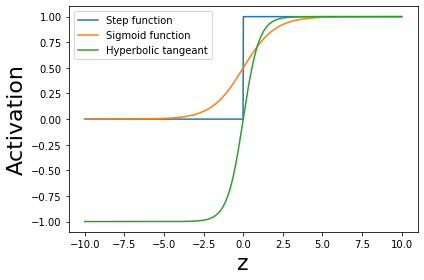

In [391]:
z = np.linspace(-10,10,1000)
plt.plot(z,step(z),label='Step function')
plt.plot(z,sigmoid(z),label='Sigmoid function')
plt.plot(z,tanh(z),label='Hyperbolic tangeant')
plt.xlabel('z',fontsize=22)
plt.ylabel('Activation',fontsize=22)
plt.legend()
plt.tight_layout()
plt.show()

__Q.6.__ Complete the function below that evaluates the output of a given layer of neurons. The function takes in the output values of the previous $(l-1)$ layer (`a0`), and the weight matrix and biases of layer $l$. The function returns a list (or an array) of the output of each neuron in layer $l$. Although it is possible to vectorize the code into a single line, we recommand you use loops first to better appreaciate the various steps of the calculation. We will use the vectorized implementation in the following weeks (3 marks).

In [395]:
def layer(a0,w,b):
    a = []
    jj,kk = w.shape
    
    ### BEGIN SOLUTION
    ### END SOLUTION
    
    return a

sizes = [3,4,2]
biases,weights = network(sizes)
a0 = np.array([[1],[1],[1]])
a1 = layer(a0,weights[0],biases[0])
a2 = layer(a1,weights[1],biases[1])
print('Output of the 1st layer (input layer):',a0)
print('Output of the 2nd layer (1st hidden layer):',a1)
print('Output of the 3rd layer (output layer):',a2)

Output of the 1st layer (input layer): [[1]
 [1]
 [1]]
Output of the 2nd layer (1st hidden layer): [array([0.99427948]), array([-0.89748925]), array([-0.10053311]), array([-0.99683224])]
Output of the 3rd layer (output layer): [array([-0.56906525]), array([-0.85246204])]
